## Import Required Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy.fft import fft2, ifft2, fftshift
import os
from IPython.display import clear_output
import time


## Load the gc_periodic function

Import the main simulation function from the converted Python file.

In [4]:
# Import the gc_periodic function
from gc_periodic import gc_periodic

## Initialize Network Parameters

**Warning:** The following are the parameters used in the associated paper. Altering them will likely lead to an unsuccessful simulation.

In [ ]:
# Timestep in ms
dt = 0.5

# Number of neurons (must be power of 2)
n = 2**7  # 128 neurons

# Neuron time-constant (in ms)
tau = 5


module = 1 s

# Envelope and Weight Matrix Parameters
lambda_param = 13 *1.4 # Equation (3)
beta = 3 / lambda_param**2  # Equation (3)
gamma = 1.05 * beta  # alphabar = gamma/beta from Equation (3)
abar = 1  # a should be <= alphabar^2. Equation (3)
wtphase = 2  # wtphase is 'l' from Equation (2)
alpha = 1 /1.4# The velocity gain from Equation (4)

# Simulation options
useSpiking = False  # Set to True for spiking model, False for rate model
filename = 'trajectory_data.npz'  # Path to trajectory data (will use random if not found)

print("Network Parameters:")
print(f"  Number of neurons: {n} x {n}")
print(f"  Time constant: {tau} ms")
print(f"  Time step: {dt} ms")
print(f"  Beta: {beta:.6f}")
print(f"  gamma: {gamma}")
print(f"  A bar: {abar}")
print(f"  Weight phase: {wtphase}")
print(f"  Velocity gain: {alpha}")
print(f"  Spiking model: {useSpiking}")

Network Parameters:
  Number of neurons: 128 x 128
  Time constant: 5 ms
  Time step: 0.5 ms
  Beta: 0.009057
  gamma: 0.009509721048182587
  A bar: 1
  Weight phase: 2
  Velocity gain: 0.7142857142857143
  Spiking model: False


Starting simulation...
This may take several minutes depending on trajectory length.



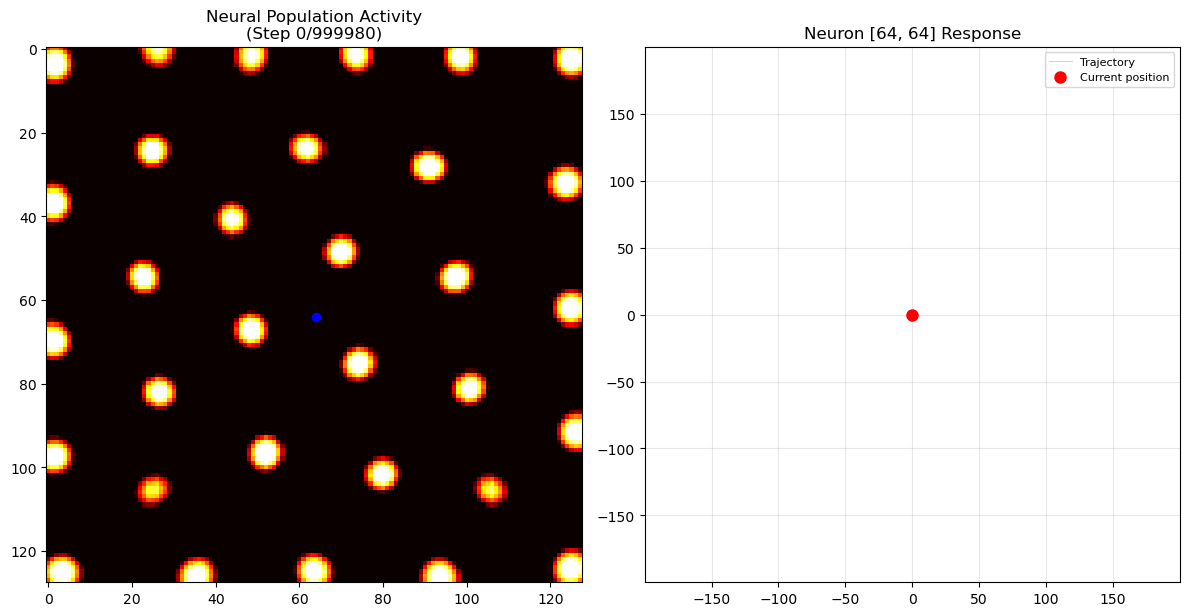

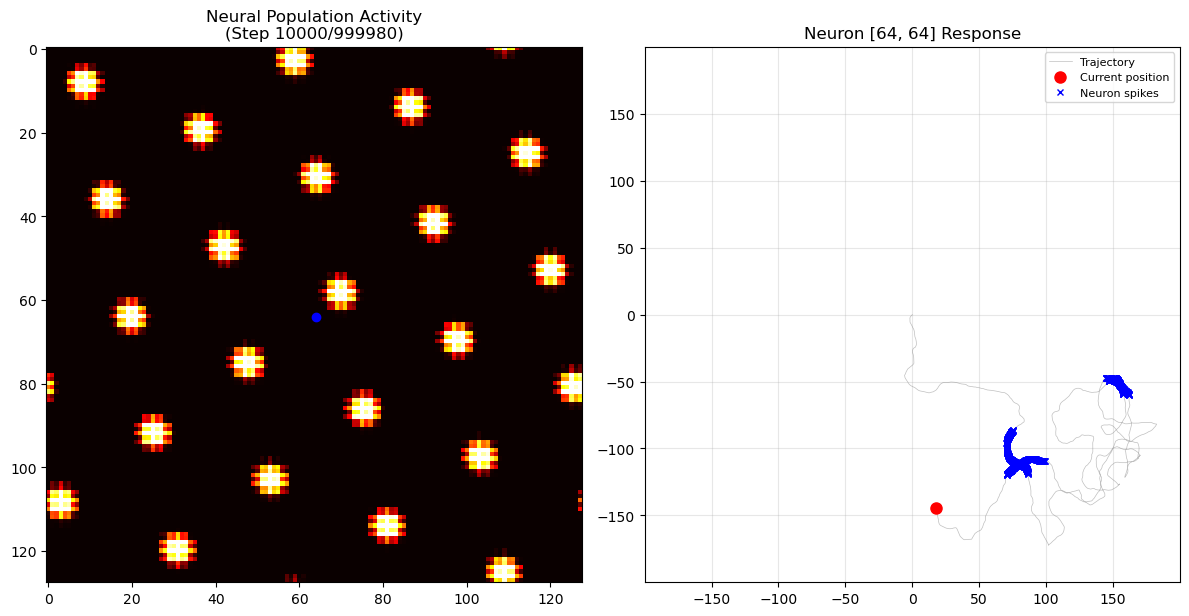

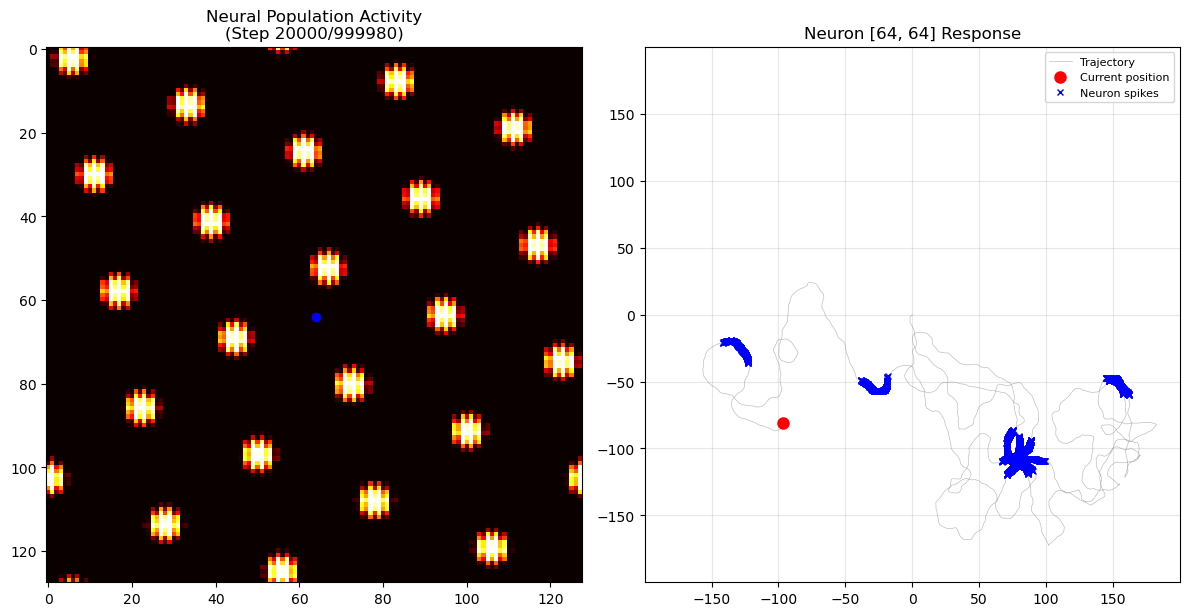

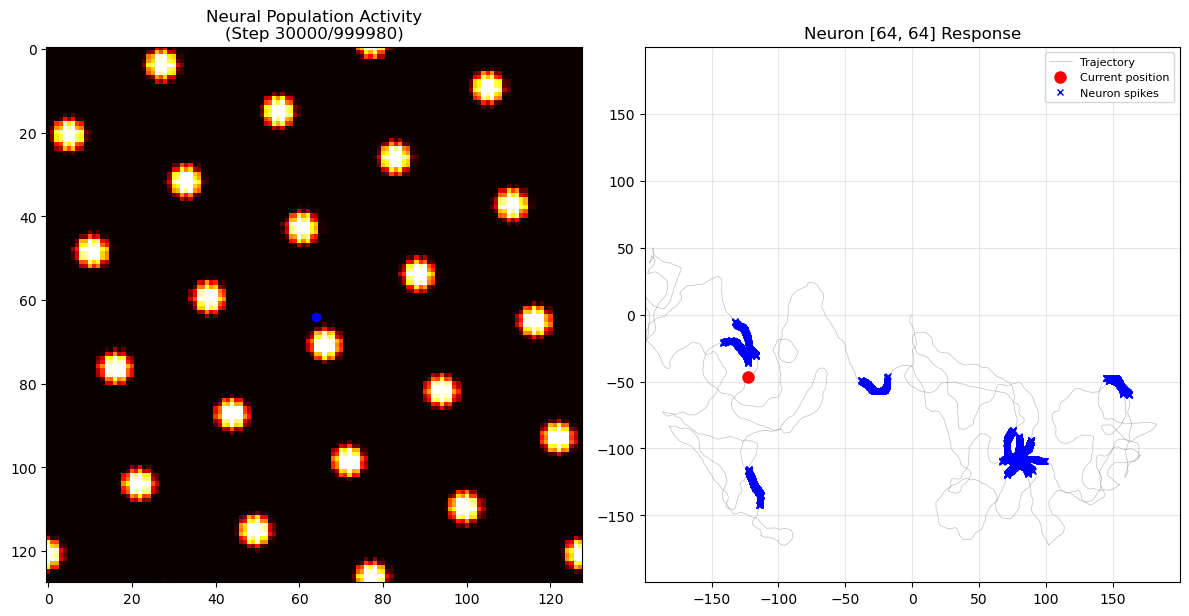

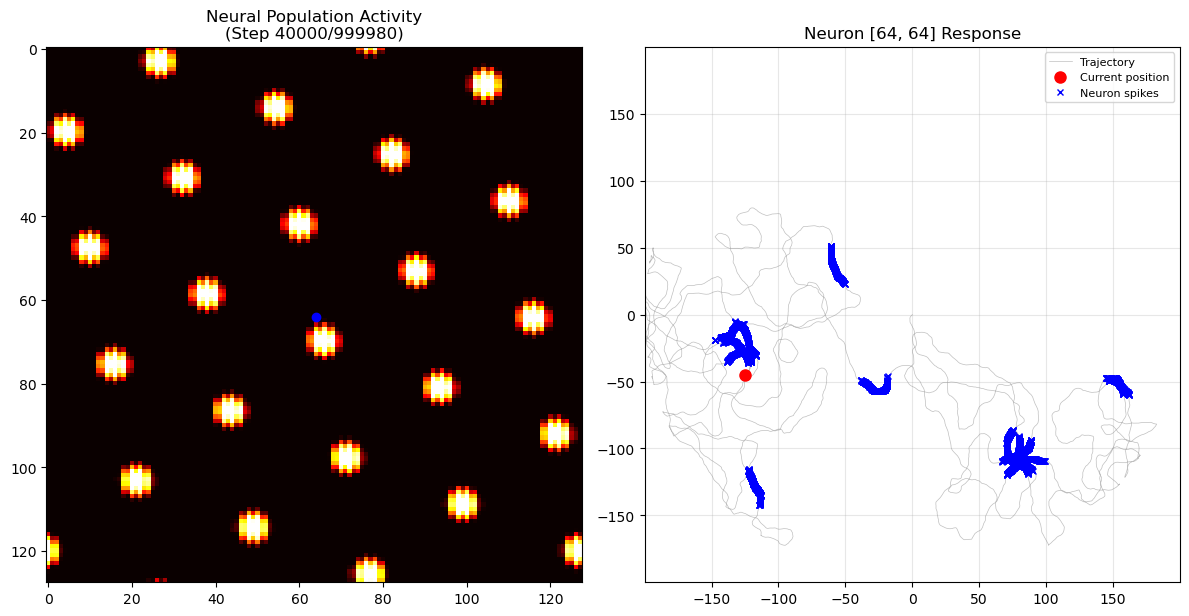

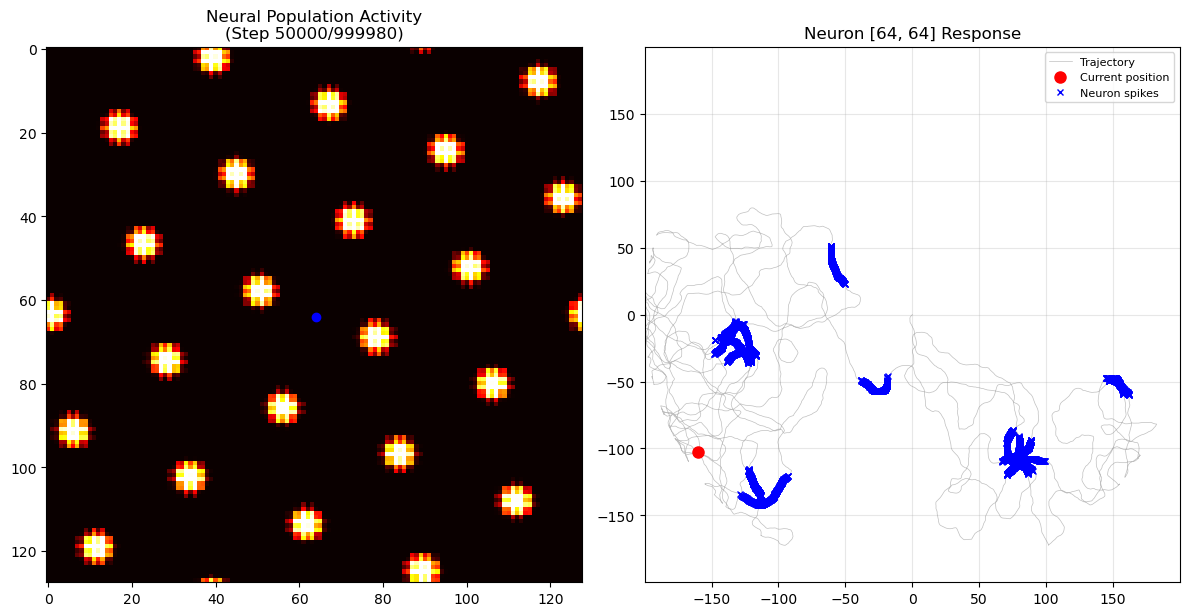

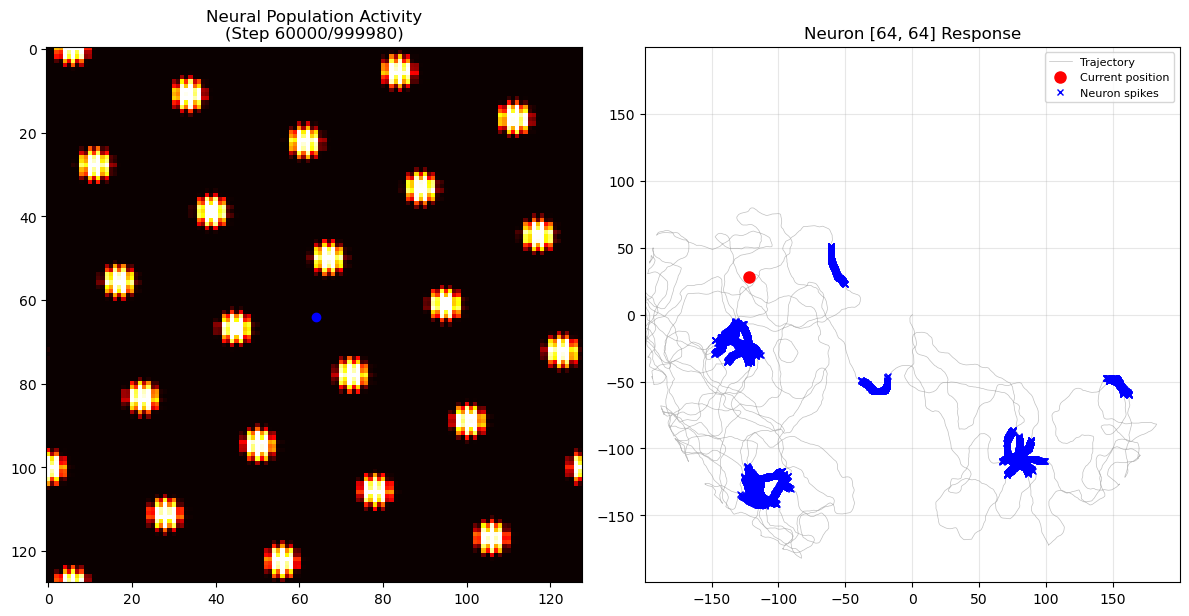

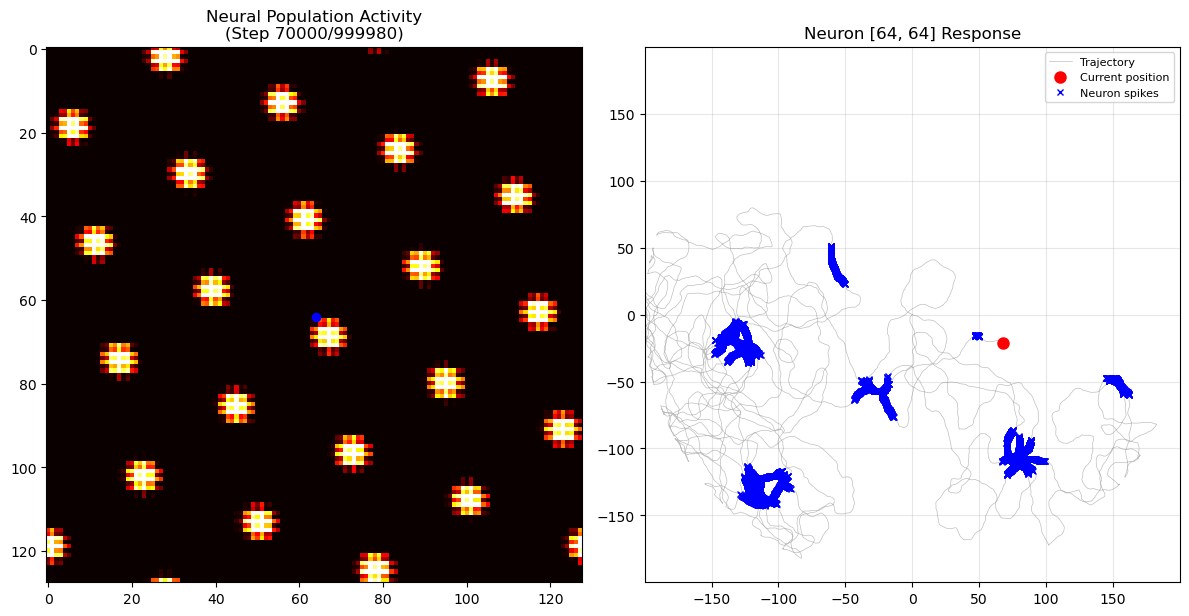

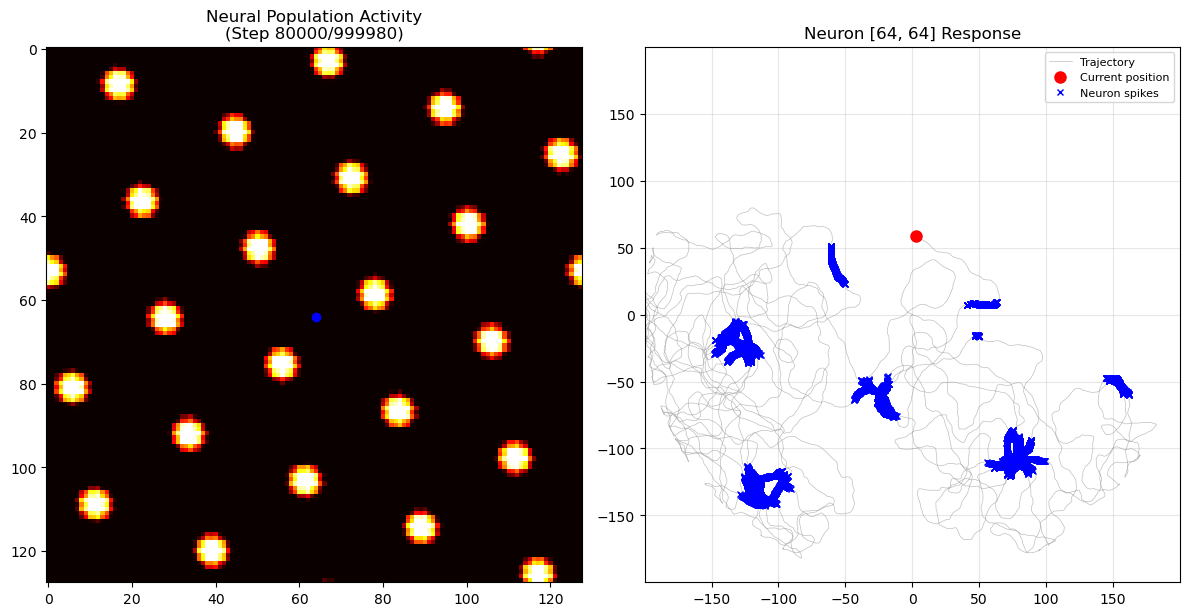

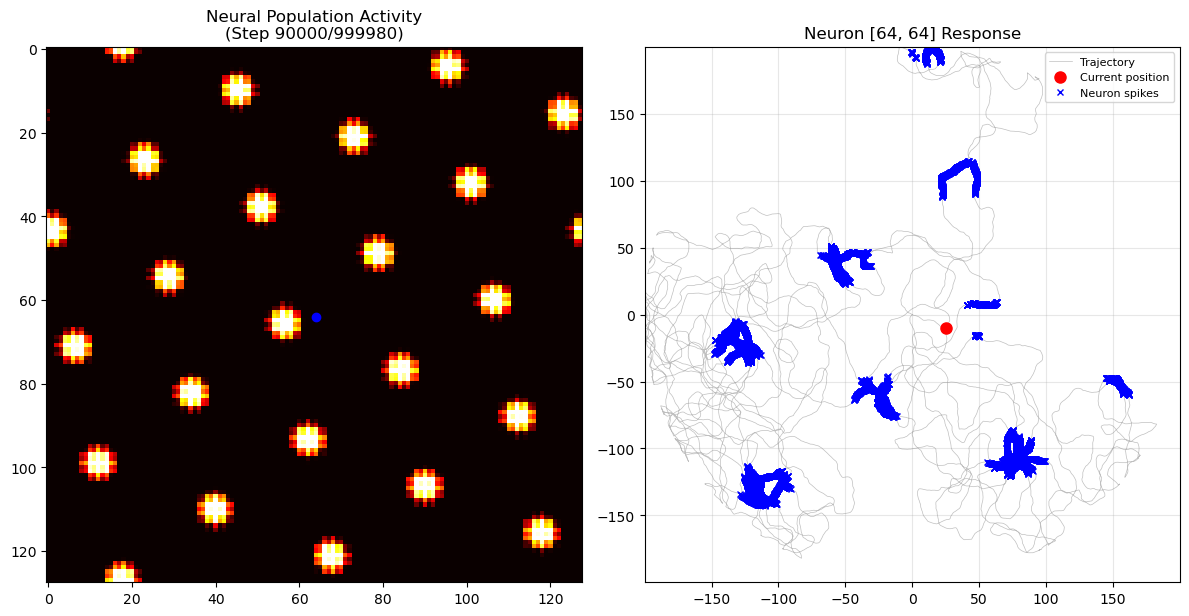

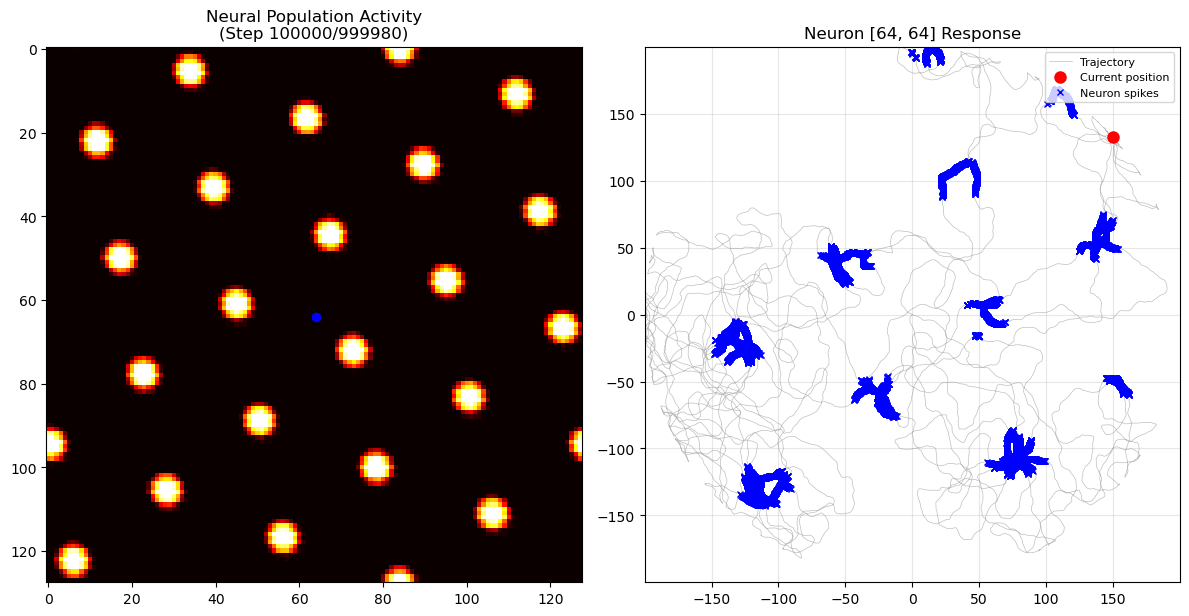

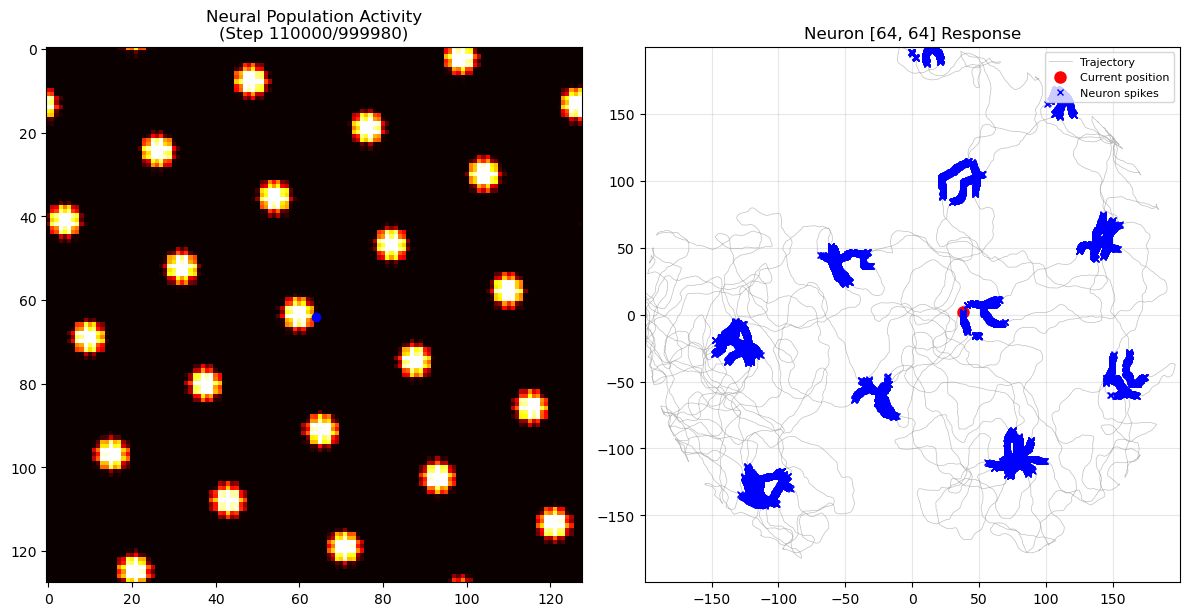

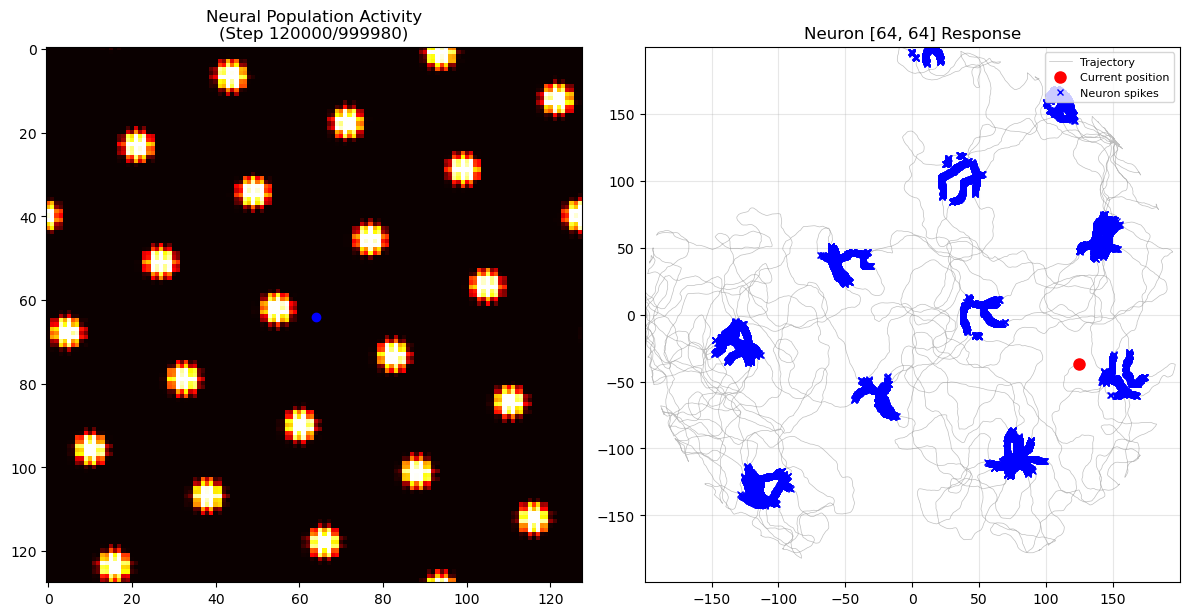

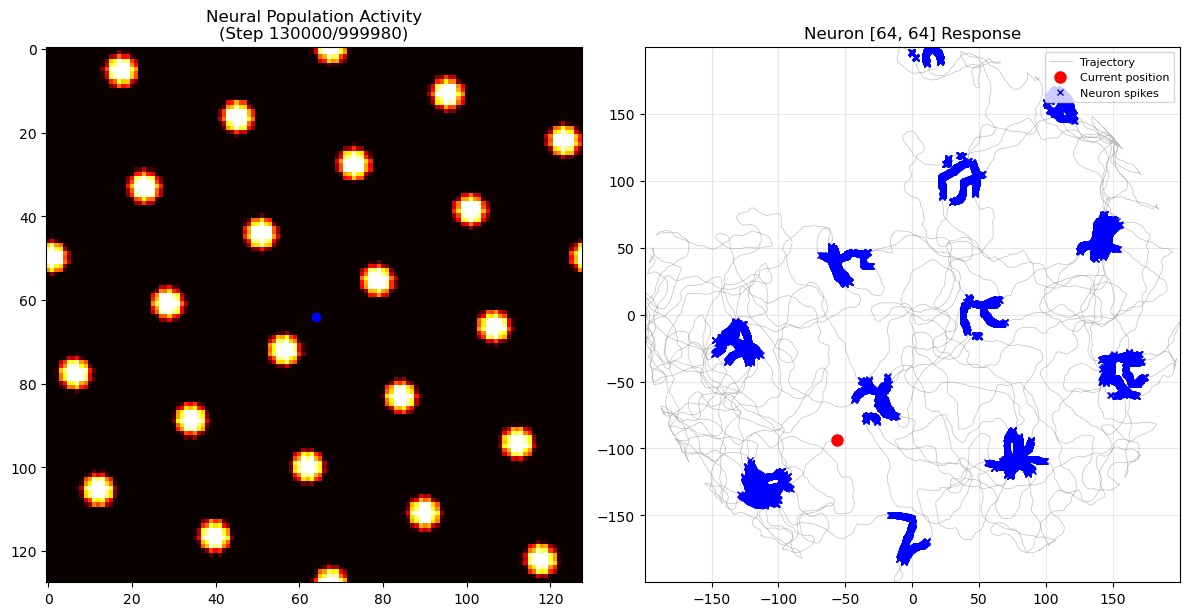

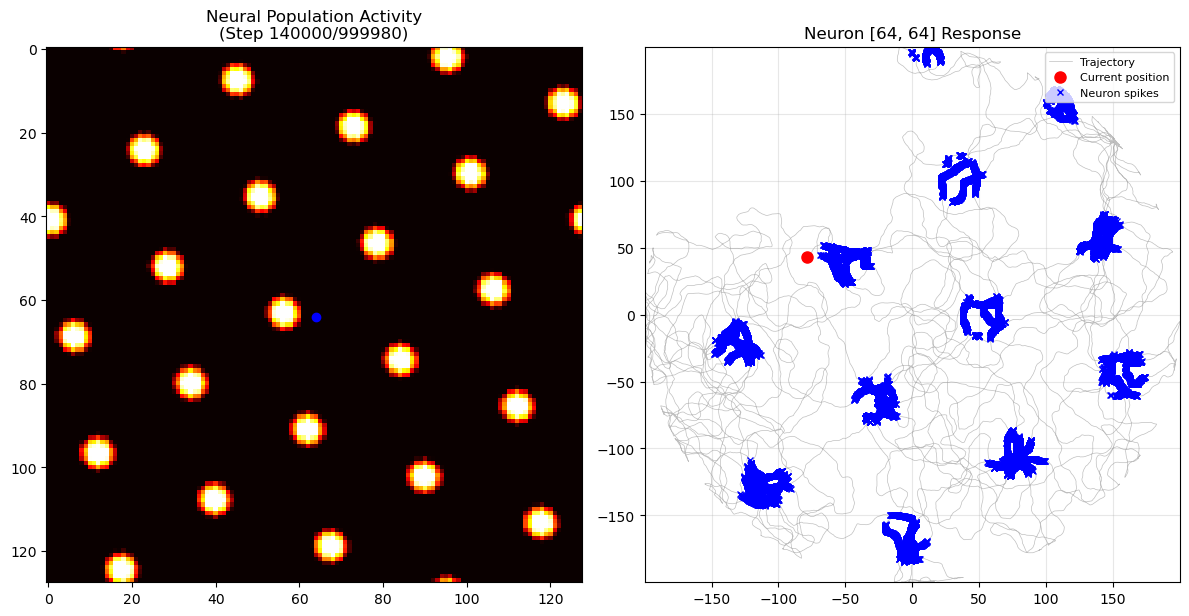

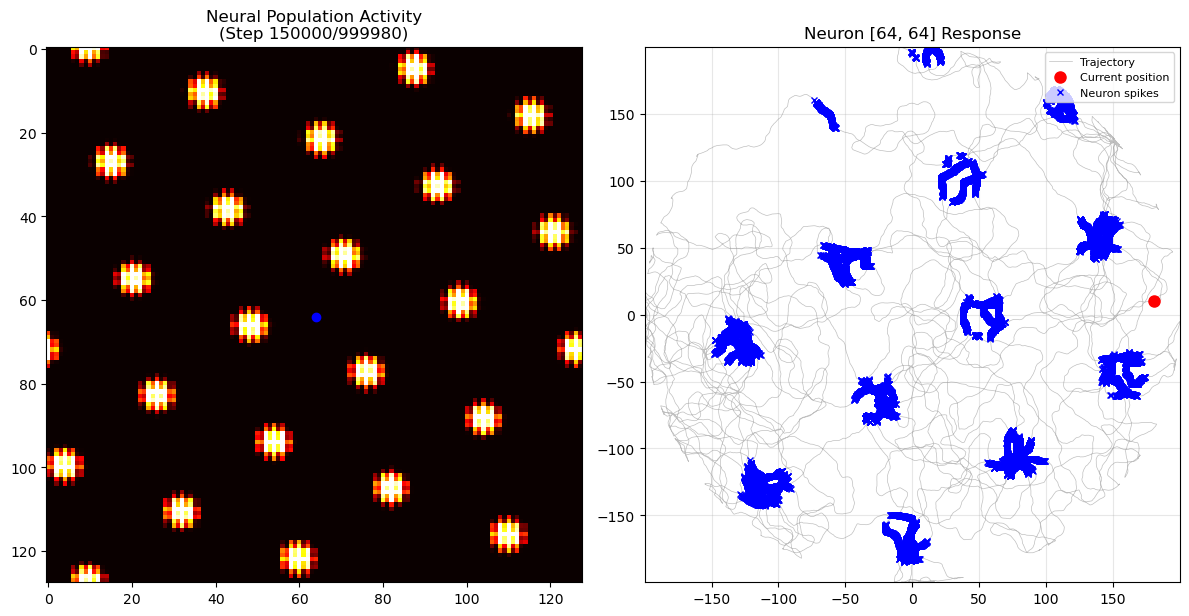

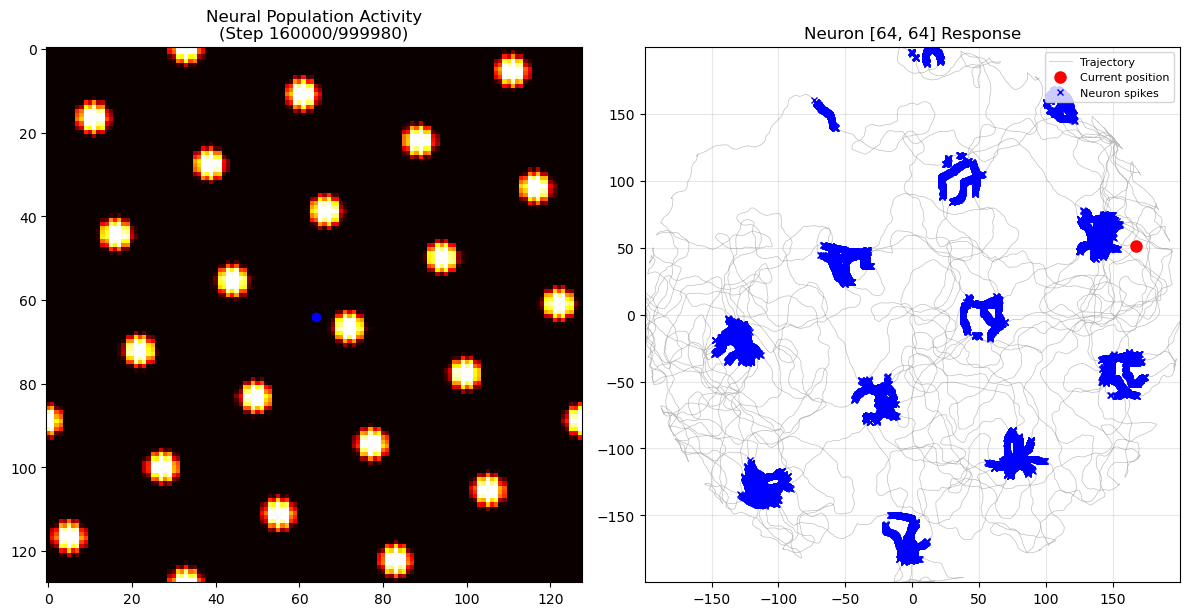

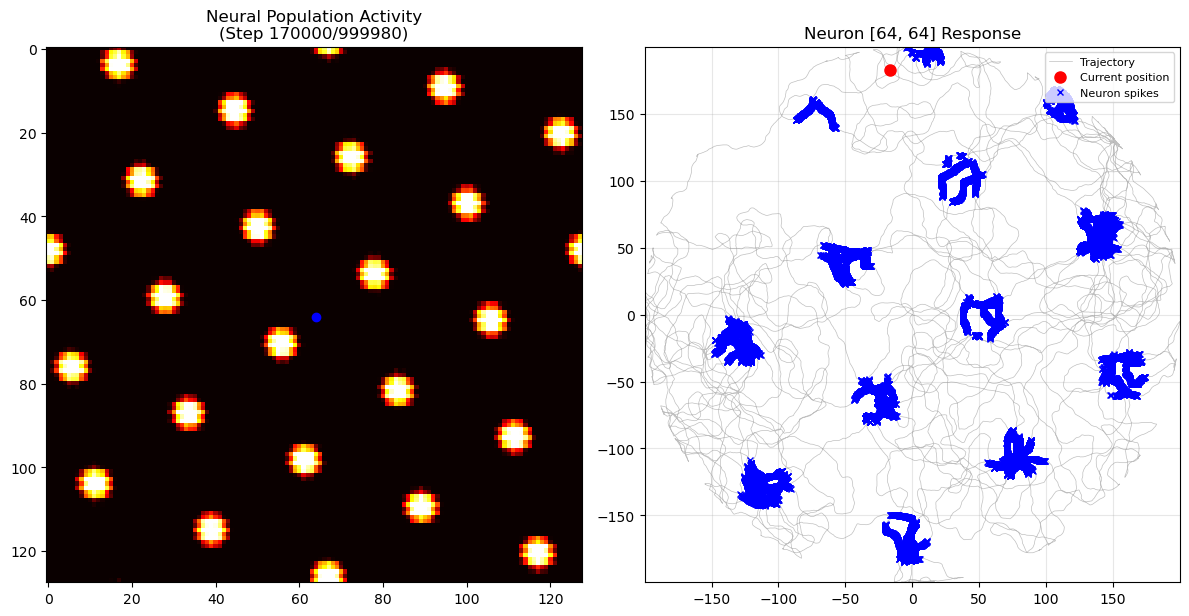

KeyboardInterrupt: 

In [30]:
# Run the simulation
print("Starting simulation...")
print("This may take several minutes depending on trajectory length.\n")

spikes = gc_periodic(
    filename=filename,
    n=n,
    tau=tau,
    dt=dt,
    beta=beta,
    gamma=gamma,
    abar=abar,
    wtphase=wtphase,
    alpha=alpha,
    useSpiking=useSpiking
)

print("\nSimulation complete!")

## Analyze Results

If spiking model was used, analyze the spike data.

In [ ]:
if useSpiking and spikes is not None:
    # Count total spikes over time
    spike_counts = []
    for spike_matrix in spikes:
        if spike_matrix is not None:
            spike_counts.append(np.sum(spike_matrix))
        else:
            spike_counts.append(0)
    
    # Plot spike count over time
    plt.figure(figsize=(12, 4))
    plt.plot(spike_counts)
    plt.xlabel('Time step')
    plt.ylabel('Total spikes in population')
    plt.title('Population Spiking Activity Over Time')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Total simulation steps: {len(spikes)}")
    print(f"Average spikes per timestep: {np.mean(spike_counts):.2f}")
    print(f"Max spikes in single timestep: {np.max(spike_counts):.0f}")
else:
    print("Rate-based model used (no spike data). See visualizations from simulation above.")

## Quick Test with Smaller Grid (Optional)

For faster testing, you can run a smaller simulation:

In [ ]:
# Uncomment to run a quick test with smaller parameters
# print("Running quick test with n=64...")
# spikes_test = gc_periodic(
#     filename='nonexistent.npz',  # Will use random trajectory
#     n=64,
#     tau=tau,
#     dt=dt,
#     beta=beta,
#     alphabar=alphabar,
#     abar=abar,
#     wtphase=wtphase,
#     alpha=alpha,
#     useSpiking=False
# )

## Notes

- The simulation generates random trajectories if no data file is provided
- Network formation occurs during the first 1000 iterations (with aperiodic boundaries)
- The envelope switches to uniform input at iteration 800
- Visualizations update every 20 time steps during the simulation
- The final plots show:
  - **Top panel**: Neural population activity (rate or spike-based)
  - **Bottom panel**: Animal trajectory with single neuron firing locations marked